In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
from os import listdir
from os.path import isfile, join

path = "../data generators/generated_trends_data/"
files = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
files = files[2:]
files

['bitcoin_daily.csv',
 'coinbase_daily.csv',
 'binance_daily.csv',
 'bitfinex_daily.csv']

## Momentum with Trend Estimation

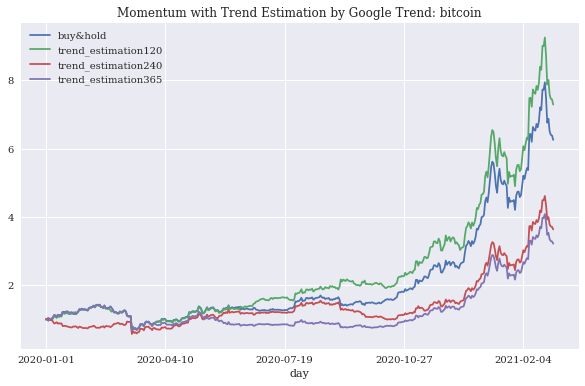

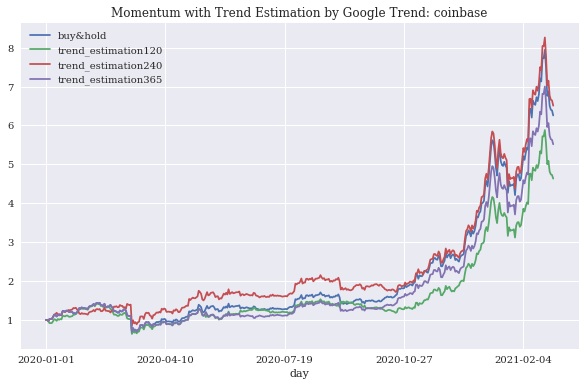

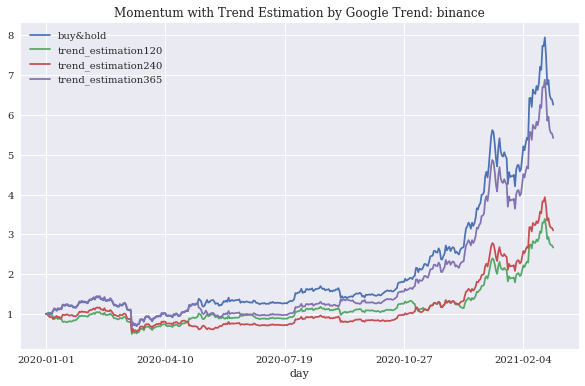

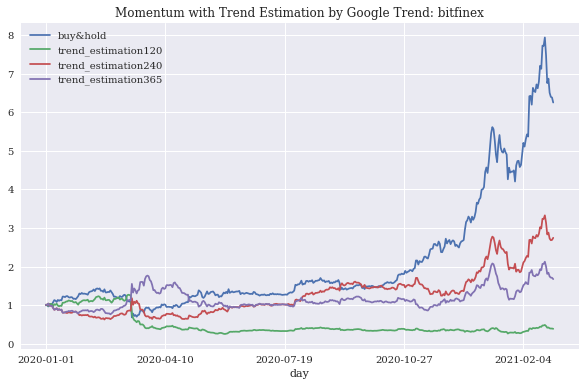

In [5]:
for file in files:
    #read file
    data = pd.read_csv("../data generators/generated_price_data/btc-usd_daily.csv")
    data = data[['market','day','close']]
    data.index = data['day']
    
    trend = pd.read_csv("../data generators/generated_trends_data/"+file)
    trend = trend[['keyword','day','trend']]
    trend.index = trend['day']

    #take proportion of the data
    test_data = data[(data['day'] >= '2019-12-31')]
    #find buy&hold strategy returns
    test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
    test_data.dropna(inplace=True)
    test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
    
    returns_data = test_data[['returns','buy&hold']].copy()
    
    trend_lengths = [120,240,365]
    for trend_length in trend_lengths:
        test_data = data[(data['day'] >= '2018-01-01')]
        last_day = data['day'].values[-1]
        test_data['trend'] = trend[(trend['day'] >= '2018-01-01') & (trend['day'] <= last_day)]['trend'].values

        #find trend estimations
        test_data['trend_estimation'] = (test_data['trend'] / test_data['trend'].shift(trend_length))-1
        
        #determine position
        col_name = 'trend_estimation'+str(trend_length)
        test_data[col_name+'_position'] = np.where(test_data['trend_estimation'] > 0, 1, -1)
        
        #find returns
        test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
        test_data[col_name+'_returns'] = test_data[col_name+'_position'].shift(1) * test_data['returns']
        test_data.dropna(inplace=True)

        #find cumulative returns
        test_data = test_data[test_data['day'] >= '2020-01-01']
        returns_data[col_name+'_returns'] = test_data[col_name+'_returns'].values
        returns_data[col_name] = (1+returns_data[col_name+'_returns'].values).cumprod()
    
    plot_columns = ['buy&hold']+['trend_estimation'+str(tl) for tl in trend_lengths]

    plot_title = "Momentum with Trend Estimation by Google Trend: "+file.split('_')[0]
    ax = returns_data[plot_columns].plot(title=plot_title,figsize=(10, 6))
    ax.get_legend()

In [30]:
#ax = test_data[['close','sma1','sma2','position']].plot(secondary_y='position',figsize=(10, 6))
#ax.get_legend()